In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.nn import functional as F
from torchvision.transforms import ToTensor
from PIL import Image
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive/', force_remount=True)
os.chdir('/content/drive/MyDrive/CPS4802FinalProject/archive 2')

Mounted at /content/drive/


In [ ]:
import pandas as pd

# Specify the actual CSV file within the directory and # Replace 'your_data.csv' with the actual name of your CSV file
csv_file_path = '/content/drive/MyDrive/CPS4802FinalProject/archive 2/gender_detection.csv'

# Read the CSV file into a DataFrame
data = pd.read_csv(csv_file_path)

# Display the head of the DataFrame
print(data.head())

                file gender  split
0  train/women/0.jpg  woman  train
1  train/women/1.jpg  woman  train
2  train/women/2.jpg  woman  train
3  train/women/3.jpg  woman  train
4  train/women/4.jpg  woman  train


In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18

# Define your transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Set the root directory to the parent folder containing class subfolders
data_path = '/content/drive/MyDrive/CPS4802FinalProject/archive 2'

# Use ResNet model
resnet_model = resnet18(pretrained=True)

# Remove the last fully connected layer (classification layer)
resnet_model = torch.nn.Sequential(*(list(resnet_model.children())[:-1]))

# Set the model to evaluation mode
resnet_model.eval()

# Apply transformations to the dataset
dataset = ImageFolder(root=data_path, transform=transform)

# Split the dataset into training and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print('Training images #: ', len(train_dataset))
print('Test images #: ', len(test_dataset))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print('Number of batches in train_loader:', len(train_loader))
print('Number of batches in test_loader:', len(test_loader))


Training images #:  240
Test images #:  60
Number of batches in train_loader: 4
Number of batches in test_loader: 1


In [ ]:
for batch in train_loader:
    x, y = batch
    # x is the input data
    # y is the corresponding label
    print("Input data shape:", x.shape)
    print("Label:", y)

Input data shape: torch.Size([64, 3, 224, 224])
Label: tensor([1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1])
Input data shape: torch.Size([64, 3, 224, 224])
Label: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1])
Input data shape: torch.Size([64, 3, 224, 224])
Label: tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])
Input data shape: torch.Size([48, 3, 224, 224])
Label: tensor([0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR

# Define the custom classifier
class CustomClassifier(nn.Module):
    def __init__(self, in_features, num_classes):
        super(CustomClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Load pre-trained ResNet18 model
resnet_model = models.resnet18(pretrained=True)

# Set requires_grad to False for all parameters in the pre-trained ResNet
for param in resnet_model.parameters():
    param.requires_grad = False

# Modify the classifier part
num_features = resnet_model.fc.in_features
custom_classifier = CustomClassifier(num_features, num_classes=2)  # Assuming 2 classes for binary classification

# Replace the final classification layer in ResNet with the custom classifier
resnet_model.fc = custom_classifier

# Move the model to GPU if available
resnet_model = resnet_model.to("cuda")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_model.parameters(), lr=0.001, momentum=0.9)  # You can adjust the lr and momentum
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Define your transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Set the root directory to the parent folder containing class subfolders
data_path = '/content/drive/MyDrive/CPS4802FinalProject/archive 2'

# Create an ImageFolder dataset
dataset = ImageFolder(root=data_path, transform=transform)

# Split the dataset into training and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Train loss: 0.6979060471057892
Test loss: 0.6575882434844971
Train loss: 0.6126690804958344
Test loss: 0.6559556722640991
Train loss: 0.5813922733068466
Test loss: 0.7185085415840149
Train loss: 0.5963013172149658
Test loss: 0.7393786907196045
Train loss: 0.5851903408765793
Test loss: 0.7094796299934387
Train loss: 0.576590895652771
Test loss: 0.6769365072250366
Train loss: 0.56428612023592
Train loss: 0.5619359239935875
Test loss: 0.6590041518211365
Train loss: 0.5539599135518074
Test loss: 0.6602274775505066
Train loss: 0.5566042214632034
Test loss: 0.667306661605835


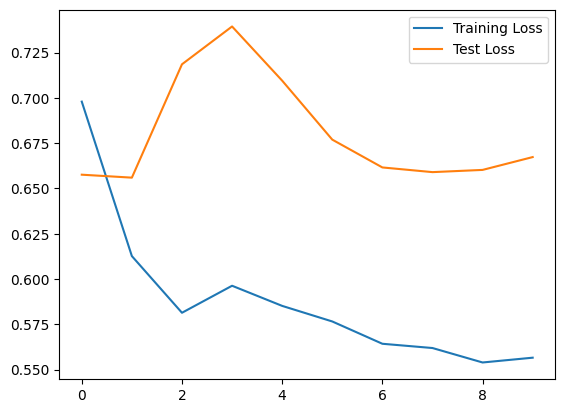

In [ ]:
# Training loop
num_epochs = 10

# Initialize lists to store training and test loss values
epoch_training_loss = []
epoch_test_loss = []

for epoch in range(num_epochs):

    resnet_model.train()  # Set the model to training mode
    epoch_loss = []
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to("cuda")
        label = label.to("cuda")

        optimizer.zero_grad()
        # feed forward
        output = resnet_model(image)
        # calculate loss
        loss = criterion(output, label)
        # Calculate Partial Derivative
        loss.backward()
        # Performs a single optimization step (parameter update).
        optimizer.step()
        epoch_loss.append(loss.item())
    print('Train loss:', np.mean(epoch_loss))
    epoch_training_loss.append(np.mean(epoch_loss))

    resnet_model.eval()  # Set the model to evaluation mode
    epoch_loss_test = []

    for batch_idx, (image, label) in enumerate(test_loader):
        image = image.to("cuda")
        label = label.to("cuda")
        optimizer.zero_grad()
        # feed forward
        output = resnet_model(image)
        # calculate loss
        loss = criterion(output, label)
        epoch_loss_test.append(loss.item())
    print('Test loss:', np.mean(epoch_loss_test))
    epoch_test_loss.append(np.mean(epoch_loss_test))

plt.plot(epoch_training_loss, label='Training Loss')
plt.plot(epoch_test_loss, label='Test Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Assuming all_labels and all_predictions are defined elsewhere in your code
all_labels = [1, 0, 1, 1, 0, 2, 2, 1]
all_predictions = [1, 0, 1, 1, 0, 2, 2, 0]

# Confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Display confusion matrix as an array
print("Confusion Matrix:")
print(cm)

# Accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print("Accuracy:", accuracy)


Confusion Matrix:
[[2 0 0]
 [1 3 0]
 [0 0 2]]
Accuracy: 0.875


In [ ]:
# Calculate error rate
error_rate = 1 - accuracy

# Extract values from the confusion matrix
true_positive = cm[1, 1]
false_positive = cm[0, 1]
true_negative = cm[0, 0]
false_negative = cm[1, 0]

# Calculate precision rate
precision_rate = true_positive / (true_positive + false_positive)

# Print error rate and precision rate
print(f"Error Rate: {error_rate:.4f}")
print(f"Precision Rate: {precision_rate:.4f}")

Error Rate: 0.1250
Precision Rate: 1.0000
